## Installation

In [ ]:
!pip3 install torch==1.8.1+cpu torchvision==0.9.1+cpu torchaudio==0.8.1 -f https://download.pytorch.org/whl/torch_stable.html

## Downloading dataset

In [ ]:
!gdown https://storage.googleapis.com/open_source_datasets/product_detection_from_packshots.tar.gz  
!mkdir destination
!tar xvzf product_detection_from_packshots.tar.gz -C /content/destination

## Cloning Repo 

- In order to detect bounding boxes, I have used a pretrained model (Yolov5) which was trained on `SKU110K` dataset. 
- I have made some changes in `detect.py` to save the `x1y1x2y2` coordinates.

In [ ]:
!git clone https://github.com/TanyaChutani/Infilect-Deep-Learning-Challenge.git

- Detecting bounding box on all products which are present on shelf and saving their coordinates in a txt file.

In [ ]:
%cd /content/Infilect-Deep-Learning-Challenge/Retail-Store-Item-Detection-using-YOLOv5
!python detect.py --weights /content/Infilect-Deep-Learning-Challenge/Retail-Store-Item-Detection-using-YOLOv5/last_yolov5s_results.pt --img 416 --conf 0.4 --source /content/destination/product_detection_from_packshots/shelf_images --save-txt

# Utility functions


- To check `image similarity`, I have used ORB similarity to check similarity between single product vs the cropped image (that came from detecting bounding box from shelf).
The best way to deal with this approach would be to use `SIAMESE NETWORK which uses contrastive loss and doesn't require much training data`, however in a short span of time I couldn't train the same. 

In [ ]:
import cv2
import random
import numpy as np
from pathlib import Path
from google.colab.patches import cv2_imshow

def orb_sim(img1, img2):
  # SIFT is no longer available in cv2 so using ORB
  orb = cv2.ORB_create()
  img1 = img1.astype(np.uint8)
  img2 = img2.astype(np.uint8)

  # detect keypoints and descriptors
  kp_a, desc_a = orb.detectAndCompute(img1, None)
  kp_b, desc_b = orb.detectAndCompute(img2, None)

  # define the bruteforce matcher object
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    
  #perform matches. 
  matches = bf.match(desc_a, desc_b)
  #Look for similar regions with distance < 50. Goes from 0 to 100 so pick a number between.
  similar_regions = [i for i in matches if i.distance < 5]  
  if len(matches) == 0:
    return 0
  return len(similar_regions) / len(matches)

def plot_one_box(x, img, color=None, label=0, line_thickness=3):
    tl = line_thickness or round(0.002 * (img.shape[0] + img.shape[1]) / 2) + 1  
    color = color or [random.randint(0, 255) for _ in range(3)]
    c1, c2 = (int(x[0]), int(x[1])), (int(x[2]), int(x[3]))
    cv2.rectangle(img, c1, c2, color, thickness=tl, lineType=cv2.LINE_AA)
    if label:
        tf = max(tl - 1, 1)  
        t_size = cv2.getTextSize(label, 0, fontScale=tl / 3, thickness=tf)[0]
        c2 = c1[0] + t_size[0], c1[1] - t_size[1] - 3
        cv2.rectangle(img, c1, c2, color, -1, cv2.LINE_AA)  
        cv2.putText(img, label, (c1[0], c1[1] - 2), 0, tl / 3, [225, 255, 255], thickness=tf, lineType=cv2.LINE_AA)


def crop_one_box(xyxy, im, file=Path('im.jpg')):
    crop = im[int(xyxy[1]):int(xyxy[3]), int(xyxy[0]):int(xyxy[2])]
    return crop

def read_img(image_path):
  img = cv2.imread(image_path)
  img  = img/255.0
  return img

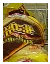

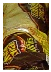

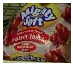

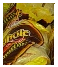

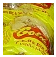

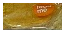

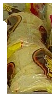

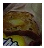

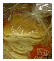

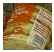

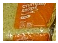

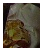

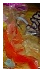

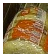

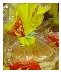

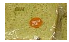

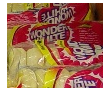

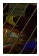

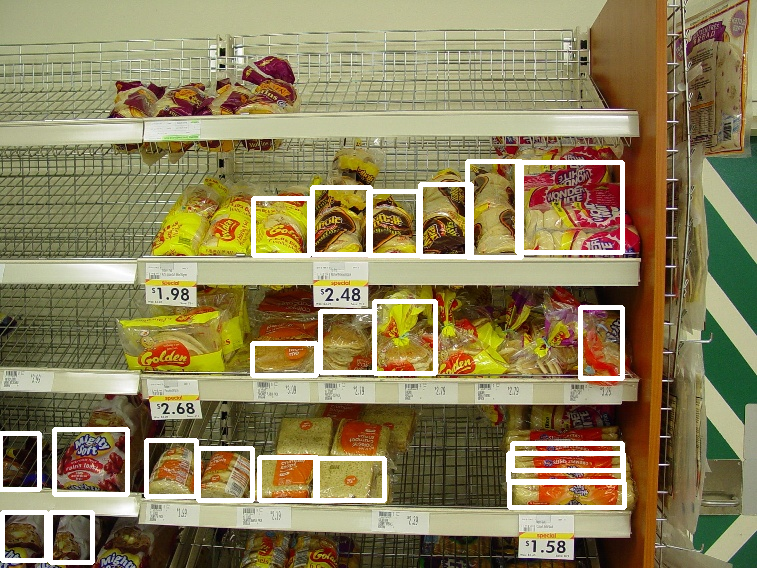

0


In [ ]:
txt_file = "/content/Infilect-Deep-Learning-Challenge/Retail-Store-Item-Detection-using-YOLOv5/inference/output/db1.txt"
image_name = "/content/destination/product_detection_from_packshots/shelf_images/db1.jpg"


img = read_img(image_name)
with open(txt_file, 'r') as fp:
    lines = fp.readlines()
    for line in lines:
      plot_one_box(line.split(" ")[-5:], img)
      crop = crop_one_box(line.split(" ")[-5:], img)
      cv2_imshow(crop*255.0)
    cv2_imshow(img*255.0)

image_new = "/content/destination/product_detection_from_packshots/product_images/qr1.jpg" 
image1 = read_img(image_new)

sim = orb_sim(crop*255.0, image1*255.0)
print(sim)

## Main function

- Lastly, I am applying ORB to check similarity between the cropped image and single product images.
- There are 100 different products present in the directory, so I am comparing with the 1st image (out of 3) vs the cropped image and showing both the images as output. 

In [ ]:
import os
txt_files = "/content/Infilect-Deep-Learning-Challenge/Retail-Store-Item-Detection-using-YOLOv5/inference/output/"
image_names = "/content/destination/product_detection_from_packshots/shelf_images/"
product_images = "/content/destination/product_detection_from_packshots/product_images/" 

for i in os.listdir(txt_files):
  if i.endswith(".txt"):
    file_name = (i.split("/")[-1]).split(".")[0]
    image_name = image_names + file_name + ".jpg"
    img = read_img(image_name)
    txt_file_name = txt_files + file_name + ".txt"
    with open(txt_file_name, 'r') as fp:
        lines = fp.readlines()
        for line in lines:
          plot_one_box(line.split(" ")[-5:], img)
          crop = crop_one_box(line.split(" ")[-5:], img)

          for idx in range(0, len(os.listdir(product_images)), 3):
            i = (sorted(os.listdir(product_images)))[idx]
            image1 = read_img(product_images+i)
            sim = orb_sim(crop*255.0, image1*255.0)
            if sim:
              cv2_imshow(crop*255.0)
              cv2_imshow(image1*255.0)